In [1]:
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import classification_report, f1_score, confusion_matrix, accuracy_score, recall_score, precision_score, make_scorer
from sklearn.pipeline import Pipeline


# Contexto

Según la Organización Mundial de la Salud (OMS), el accidente cerebrovascular (ACV) es la segunda causa principal de muerte a nivel mundial, responsable de aproximadamente el 11% del total de muertes.
Este conjunto de datos se utiliza para predecir si es probable que un paciente sufra un accidente cerebrovascular en función de los parámetros de entrada como el sexo, la edad, diversas enfermedades y el tabaquismo. Cada fila de los datos proporciona información relevante sobre el paciente.

Información de los atributos del dataset
1. id: identificación
2. gender: sexo biológico del paciente
3. age: edad
4. hypertension: YES/NO si el paciente tiene o no hipertensión
5. heart_disease: YES/NO si el paciente tiene o no alguna enfermedad vinculada al corazón
6. ever_married: YES/NO si el paciente se caso alguna vez
7. work_type: indica el estado de empleabilidad del paciente
8. Residence_type: indica si el paciente vive en una zona rural o urbana
9. avg_glucose_level: nivel de glucosa en sangre en ayunas 
10. bmi: índice de masa corporal
11. smoking_status: indica si el paciente ha fumado, fuma o se desconoce
12. stroke: YES/NO si el paciente tuvo un accidente cerebrovascular


https://www.kaggle.com/fedesoriano/stroke-prediction-dataset

## Exploración inicial del dataset

In [2]:
# Cargamos el dataset
df= pd.read_csv('..\Downloads\healthcare-dataset-stroke-data.csv', sep=';')
df.head(5)

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,9046,Male,67.0,NO,YES,Yes,Private,Urban,228.69,36.6,formerly smoked,YES
1,51676,Female,61.0,NO,NO,Yes,Self-employed,Rural,202.21,NaN,never smoked,YES
2,31112,Male,80.0,NO,YES,Yes,Private,Rural,105.92,32.5,never smoked,YES
3,60182,Female,49.0,NO,NO,Yes,Private,Urban,171.23,34.4,smokes,YES
4,1665,Female,79.0,YES,NO,Yes,Self-employed,Rural,174.12,24.0,never smoked,YES


In [3]:
df['stroke'].value_counts(normalize = True)

NO     0.95382
YES    0.04618
Name: stroke, dtype: float64

In [4]:
df[df['stroke']== 'YES'].describe()

,id,age,avg_glucose_level,bmi
count,249.000000,249.000000,249.000000,209.000000
mean,37115.068273,67.728193,132.544739,30.471292
std,21993.344872,12.727419,61.921056,6.329452
min,210.000000,1.320000,56.110000,16.900000
25%,17013.000000,59.000000,79.790000,26.400000
50%,36706.000000,71.000000,105.220000,29.700000
75%,56669.000000,78.000000,196.710000,33.700000
max,72918.000000,82.000000,271.740000,56.600000


Procedemos a inspeccionarlo, en busca de valores faltantes, datos incongruentes y posibilidades de cambios.

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5392 entries, 0 to 5391
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   id                 5392 non-null   int64  
 1   gender             5392 non-null   object 
 2   age                5392 non-null   float64
 3   hypertension       5392 non-null   object 
 4   heart_disease      5392 non-null   object 
 5   ever_married       5392 non-null   object 
 6   work_type          5392 non-null   object 
 7   Residence_type     5392 non-null   object 
 8   avg_glucose_level  5392 non-null   float64
 9   bmi                5182 non-null   float64
 10  smoking_status     5392 non-null   object 
 11  stroke             5392 non-null   object 
dtypes: float64(3), int64(1), object(8)
memory usage: 505.6+ KB


### Búsqueda de nulos y datos faltantes

In [6]:
df["smoking_status"].value_counts()

never smoked       1997
Unknown            1634
formerly smoked     929
smokes              832
Name: smoking_status, dtype: int64

Vemos que la tabla posee gran cantidad de datos "Unknown" para la categoría de fumador. Esto será un punto a tener en cuenta más adelante.


In [7]:
pd.crosstab(df.smoking_status.fillna('vacio'), df.stroke.fillna('vacio'), normalize='columns', margins=True).style.format('{:.2%}')

stroke,NO,YES,All
smoking_status,,,
Unknown,30.86%,18.88%,30.30%
formerly smoked,16.70%,28.11%,17.23%
never smoked,37.08%,36.14%,37.04%
smokes,15.36%,16.87%,15.43%


In [8]:
df[df['age']<10]['smoking_status'].value_counts()

Unknown    504
Name: smoking_status, dtype: int64

Vemos que el estado de si fuma para menores de diez años es Unknown, podemos imputar estos datos como never smoke, ya que es poco probable que fumen a esa edad.

In [9]:
df.loc[df.age < 10, 'smoking_status'] = 'never smoked'

In [10]:
df[df['age']<10]['smoking_status'].value_counts()

never smoked    504
Name: smoking_status, dtype: int64

Chequeamos si el dataframe posee valores nulos en alguna de las columnas

In [11]:
df.isna().sum()

id                     0
gender                 0
age                    0
hypertension           0
heart_disease          0
ever_married           0
work_type              0
Residence_type         0
avg_glucose_level      0
bmi                  210
smoking_status         0
stroke                 0
dtype: int64

Podemos ver que en BMI tenemos valores nulos. Vamos a dropearlos ya que no son una gran cantidad y es una medida dificil de imputar de otra forma

In [12]:
# Dropeo de valores nulos de de BMI
df['bmi'] = df['bmi'].apply(pd.to_numeric, errors = 'coerce') 
df.head(5)

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,9046,Male,67.0,NO,YES,Yes,Private,Urban,228.69,36.6,formerly smoked,YES
1,51676,Female,61.0,NO,NO,Yes,Self-employed,Rural,202.21,NaN,never smoked,YES
2,31112,Male,80.0,NO,YES,Yes,Private,Rural,105.92,32.5,never smoked,YES
3,60182,Female,49.0,NO,NO,Yes,Private,Urban,171.23,34.4,smokes,YES
4,1665,Female,79.0,YES,NO,Yes,Self-employed,Rural,174.12,24.0,never smoked,YES


In [13]:
df = df.dropna(axis = 0) #eliminamos las filas con BMI = NaN
df = df.reset_index(drop=True) #Reseteamos los indices del dataframe
df.head(5) #chequeamos haber dropeado el primer NaN identificado

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,9046,Male,67.0,NO,YES,Yes,Private,Urban,228.69,36.6,formerly smoked,YES
1,31112,Male,80.0,NO,YES,Yes,Private,Rural,105.92,32.5,never smoked,YES
2,60182,Female,49.0,NO,NO,Yes,Private,Urban,171.23,34.4,smokes,YES
3,1665,Female,79.0,YES,NO,Yes,Self-employed,Rural,174.12,24.0,never smoked,YES
4,56669,Male,81.0,NO,NO,Yes,Private,Urban,186.21,29.0,formerly smoked,YES


In [14]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5182 entries, 0 to 5181
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   id                 5182 non-null   int64  
 1   gender             5182 non-null   object 
 2   age                5182 non-null   float64
 3   hypertension       5182 non-null   object 
 4   heart_disease      5182 non-null   object 
 5   ever_married       5182 non-null   object 
 6   work_type          5182 non-null   object 
 7   Residence_type     5182 non-null   object 
 8   avg_glucose_level  5182 non-null   float64
 9   bmi                5182 non-null   float64
 10  smoking_status     5182 non-null   object 
 11  stroke             5182 non-null   object 
dtypes: float64(3), int64(1), object(8)
memory usage: 485.9+ KB


Además de los nulos, vemos si hay registros duplicados dentro del dataframe que podamos limpiar

### Eliminación de duplicados

In [15]:
df.duplicated().sum()

273

In [16]:
df[df.duplicated()]

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
4909,42091,Male,32.00,NO,NO,Yes,Govt_job,Rural,83.01,25.8,smokes,NO
4910,66067,Male,66.00,NO,NO,Yes,Private,Rural,67.92,31.1,formerly smoked,NO
4911,50222,Female,22.00,NO,NO,No,Private,Rural,74.99,27.9,smokes,NO
4912,41214,Female,1.32,NO,NO,No,children,Rural,75.22,18.6,never smoked,NO
4913,72386,Female,20.00,NO,NO,No,Private,Urban,61.88,20.1,never smoked,NO
...,...,...,...,...,...,...,...,...,...,...,...,...
5177,14180,Female,13.00,NO,NO,No,children,Rural,103.08,18.6,Unknown,NO
5178,44873,Female,81.00,NO,NO,Yes,Self-employed,Urban,125.20,40.0,never smoked,NO
5179,19723,Female,35.00,NO,NO,Yes,Self-employed,Rural,82.99,30.6,never smoked,NO
5180,37544,Male,51.00,NO,NO,Yes,Private,Rural,166.29,25.6,formerly smoked,NO


Efectivamente hay duplicados y procedemos a eliminarlos.

In [17]:
df.drop_duplicates(keep = "first", inplace = True)
df = df.reset_index(drop=True) #Reseteamos los indices del dataframe

In [18]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4909 entries, 0 to 4908
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   id                 4909 non-null   int64  
 1   gender             4909 non-null   object 
 2   age                4909 non-null   float64
 3   hypertension       4909 non-null   object 
 4   heart_disease      4909 non-null   object 
 5   ever_married       4909 non-null   object 
 6   work_type          4909 non-null   object 
 7   Residence_type     4909 non-null   object 
 8   avg_glucose_level  4909 non-null   float64
 9   bmi                4909 non-null   float64
 10  smoking_status     4909 non-null   object 
 11  stroke             4909 non-null   object 
dtypes: float64(3), int64(1), object(8)
memory usage: 460.3+ KB


Veamos ahora si hay valores que podamos considerar como atípicos, alguno de los registros numéricos.

In [19]:
df.describe()

,id,age,avg_glucose_level,bmi
count,4909.000000,4909.000000,4909.000000,4909.000000
mean,37064.313506,42.865374,105.305150,28.893237
std,20995.098457,22.555115,44.424341,7.854067
min,77.000000,0.080000,55.120000,10.300000
25%,18605.000000,25.000000,77.070000,23.500000
50%,37608.000000,44.000000,91.680000,28.100000
75%,55220.000000,60.000000,113.570000,33.100000
max,72940.000000,82.000000,271.740000,97.600000


Revisamos los valores min y max de bmi en busca de outlier

In [20]:
df[df['bmi']> 95]

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
2019,56420,Male,17.0,YES,NO,No,Private,Rural,61.67,97.6,Unknown,NO


In [21]:
df[df['bmi']< 11]

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
1526,38043,Female,1.24,NO,NO,No,children,Rural,122.04,10.3,never smoked,NO


Vamos a eliminar el dato de bmi max, ya que parece ser un outlier por la edad y nivel de glucosa normal, no podria tener ese alto bmi

In [22]:
df.drop(2019, axis = 0, inplace = True)

Vamos a revisar los valores en gender en busca de outliers

In [23]:
df['gender'].value_counts()

Female    2897
Male      2010
Other        1
Name: gender, dtype: int64

In [24]:
df[df['gender']=='Other']
df.drop(2970, inplace = True) ##Dropeamos el gender = Other
df = df.reset_index(drop=True) #Reseteamos los indices del dataframe

#### Segmentación de variables 

Procedemos a realizar una segmentación de las variables de glucosa en sangre y el peso, para producir variables categoricas vinculadas a estas variables respaldandonos en información de la OMS

In [25]:
df['Diabetes'] = pd.cut(df['avg_glucose_level'], [0, 100, 125, 500], labels = ['normal', 'prediabetes', 'diabetes'])

In [26]:
df['Peso'] = pd.cut(df['bmi'],[18.5, 24.9, 29.9, 39.9, 200], labels = ['normal', 'sobrepeso', 'obesidad', 'obesidad extrema'])

## Creación de columnas Dummies
Procedemos a transformar las variable categóricas que consideramos importantes
    


In [27]:
dummy_tension = pd.get_dummies(df['hypertension'], drop_first = True)
dummy_tension.rename(columns = {1:'Hipertension'}, inplace = True)


In [28]:
dummy_heart = pd.get_dummies(df['heart_disease'], drop_first = True)
dummy_heart.rename(columns = {1:'Cardiaco'}, inplace = True)


In [29]:
dummy_married = pd.get_dummies(df['ever_married'], drop_first = True)


In [30]:
dummy_residence = pd.get_dummies(df['Residence_type'], drop_first = True) 
#Nos interesa saber si vivir en la ciudad tambien es un valor que afecta la salud cardiaca de los pacientes


In [31]:
dummy_stroke = pd.get_dummies(df['stroke'], drop_first = True)
dummy_stroke.rename(columns = {1:'ACV'}, inplace = True)


In [32]:
dummy_gender = pd.get_dummies(df['gender'], drop_first = True)


In [33]:
dummy_work = pd.get_dummies(df['work_type'], drop_first = True)


In [34]:
dummy_smoke = pd.get_dummies(df['smoking_status'], drop_first = True)


In [35]:
dummy_peso = pd.get_dummies(df['Peso'], drop_first = True)


In [36]:
dummy_diabetes = pd.get_dummies(df['Diabetes'], drop_first = True)


Investigamos que después de los 55 años aumentan las posibilidades de padecer un ACV, por lo que vamos a crear una columna de edad de riesgo.

In [37]:
mayor_55 = df['age'].apply(lambda x: 1 if x > 55 else 0)
df['edad_riesgo']= mayor_55


Una vez obtenidas estas variables, las agregamos al final de nuestro dataframe e imprimimos los 5 primeros registros para ver que fueron correctamente transformados

In [38]:
df = pd.concat([df,dummy_tension],axis=1)
df.rename(columns = {'YES':'Hipertension'}, inplace = True)
df.head()

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke,Diabetes,Peso,edad_riesgo,Hipertension
0,9046,Male,67.0,NO,YES,Yes,Private,Urban,228.69,36.6,formerly smoked,YES,diabetes,obesidad,1,0
1,31112,Male,80.0,NO,YES,Yes,Private,Rural,105.92,32.5,never smoked,YES,prediabetes,obesidad,1,0
2,60182,Female,49.0,NO,NO,Yes,Private,Urban,171.23,34.4,smokes,YES,diabetes,obesidad,0,0
3,1665,Female,79.0,YES,NO,Yes,Self-employed,Rural,174.12,24.0,never smoked,YES,diabetes,normal,1,1
4,56669,Male,81.0,NO,NO,Yes,Private,Urban,186.21,29.0,formerly smoked,YES,diabetes,sobrepeso,1,0


In [39]:
df = pd.concat([df,dummy_heart],axis=1)
df.rename(columns = {'YES':'Cardiacos'}, inplace = True)


In [40]:
df = pd.concat([df,dummy_married],axis=1)
df.rename(columns = {'Yes':'Casados'}, inplace = True)


In [41]:
df = pd.concat([df,dummy_residence],axis=1)
df.rename(columns = {'Urban':'Ciudad'}, inplace = True)


In [42]:
df = pd.concat([df,dummy_gender],axis=1)    ## 1 = Hombre, 0 = Mujer
df.rename(columns = {'Male':'Genero'}, inplace = True)


In [43]:
df = pd.concat([df,dummy_work],axis=1)


In [44]:
df = pd.concat([df,dummy_smoke],axis=1)


In [45]:
df = pd.concat([df,dummy_stroke],axis=1)
df.rename(columns = {'YES':'ACV'}, inplace = True)


In [46]:
df = pd.concat([df,dummy_peso],axis=1)


In [47]:
df = pd.concat([df,dummy_diabetes],axis=1)


Una vez hecho esto, creamos un nuevo data Frame, dondelos valores alfabeticos de las variables importantes no estén

In [48]:
df_2 = df.drop(['gender','bmi','avg_glucose_level','Diabetes','Peso','work_type', 'hypertension', 'heart_disease', 'ever_married', 'Residence_type', 'stroke','smoking_status'], axis = 1)
#df_2 = df.drop(['gender','bmi','avg_glucose_level','work_type', 'hypertension', 'heart_disease', 'ever_married', 'Residence_type', 'stroke','smoking_status'], axis = 1)


Por último, dropeamos la columna ID, ya que no será útil.

In [49]:
df_2 = df_2.drop('id', axis=1)


In [50]:
df_2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4907 entries, 0 to 4906
Data columns (total 20 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   age               4907 non-null   float64
 1   edad_riesgo       4907 non-null   int64  
 2   Hipertension      4907 non-null   uint8  
 3   Cardiacos         4907 non-null   uint8  
 4   Casados           4907 non-null   uint8  
 5   Ciudad            4907 non-null   uint8  
 6   Genero            4907 non-null   uint8  
 7   Never_worked      4907 non-null   uint8  
 8   Private           4907 non-null   uint8  
 9   Self-employed     4907 non-null   uint8  
 10  children          4907 non-null   uint8  
 11  formerly smoked   4907 non-null   uint8  
 12  never smoked      4907 non-null   uint8  
 13  smokes            4907 non-null   uint8  
 14  ACV               4907 non-null   uint8  
 15  sobrepeso         4907 non-null   uint8  
 16  obesidad          4907 non-null   uint8  


#### Nuevas variables para entrenar el modelo

In [51]:
df_2['age4']= df.age**4
df_2["agelog"] = np.log(df.age)
df_2["agebmi"] = df.age * df.bmi
df_2["ageavg"] = df.age * df.avg_glucose_level
df_2["avgbmi"] = df.avg_glucose_level * df.bmi
df_2["INDICE"]= df.bmi
df_2["glucosa"] = df.avg_glucose_level
df_2.edad_riesgo.astype(int)
df_2.info()
df_2.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4907 entries, 0 to 4906
Data columns (total 27 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   age               4907 non-null   float64
 1   edad_riesgo       4907 non-null   int64  
 2   Hipertension      4907 non-null   uint8  
 3   Cardiacos         4907 non-null   uint8  
 4   Casados           4907 non-null   uint8  
 5   Ciudad            4907 non-null   uint8  
 6   Genero            4907 non-null   uint8  
 7   Never_worked      4907 non-null   uint8  
 8   Private           4907 non-null   uint8  
 9   Self-employed     4907 non-null   uint8  
 10  children          4907 non-null   uint8  
 11  formerly smoked   4907 non-null   uint8  
 12  never smoked      4907 non-null   uint8  
 13  smokes            4907 non-null   uint8  
 14  ACV               4907 non-null   uint8  
 15  sobrepeso         4907 non-null   uint8  
 16  obesidad          4907 non-null   uint8  


,age,edad_riesgo,Hipertension,Cardiacos,Casados,Ciudad,Genero,Never_worked,Private,Self-employed,...,obesidad extrema,prediabetes,diabetes,age4,agelog,agebmi,ageavg,avgbmi,INDICE,glucosa
0,67.0,1,0,1,1,1,1,0,1,0,...,0,0,1,20151121.0,4.204693,2452.2,15322.23,8370.054,36.6,228.69
1,80.0,1,0,1,1,0,1,0,1,0,...,0,1,0,40960000.0,4.382027,2600.0,8473.60,3442.400,32.5,105.92
2,49.0,0,0,0,1,1,0,0,1,0,...,0,0,1,5764801.0,3.891820,1685.6,8390.27,5890.312,34.4,171.23
3,79.0,1,1,0,1,0,0,0,0,1,...,0,0,1,38950081.0,4.369448,1896.0,13755.48,4178.880,24.0,174.12
4,81.0,1,0,0,1,1,1,0,1,0,...,0,0,1,43046721.0,4.394449,2349.0,15083.01,5400.090,29.0,186.21


## Valores de interés
Buscamos información relevante para poder evalutar, o generar categorías, que nos permitan predecir si el paciente está en riesgo de tener un ACV.

#### Glucosa
    Tomamos como parámetro el estudio más común, que es el de glucosa en plasma en ayunas.
    Un nivel de glucosa sanguínea:
        Inferior a 100 mg/dl se considera normal.
        Entre 100 y 125 mg/dL se considera prediabetes.
        Mayor a 126 mg/dl se considera diabetes.
https://dtc.ucsf.edu/es/tipos-de-diabetes/diabetes-tipo-1/comprension-de-la-diabetes-tipo-1/datos-basicos/diagnostico-de-la-diabetes/
        
#### Edad de riesgo
    Tener 55 años o más: a partir de los 55 años, se duplica la tasa de muerte por ACV cada 10 años.

#### BMI
    Para los adultos, un BMI de:
        18,5 a 24,9 se considera peso normal.
        25,0 a 29,9 se considera sobrepeso.
        30,0 a 39,9 se considera obesidad.
        40,0 o más se considera obesidad extrema o mórbida.

Vamos a ver la correlacion entre las variables

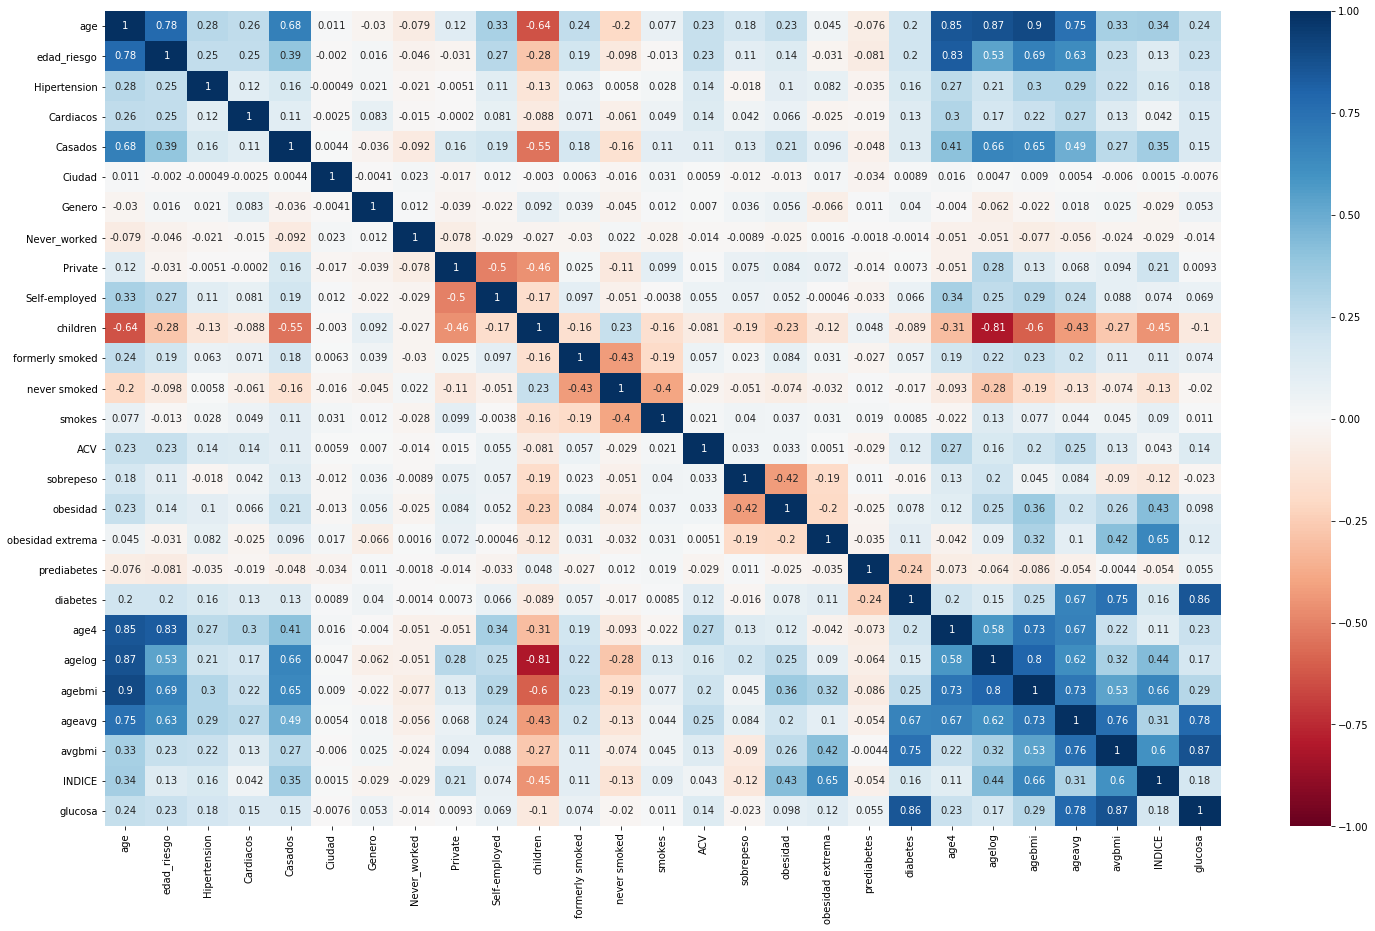

In [52]:
plt.figure(figsize = (25,15))
sns.heatmap(df_2.corr(),vmin=-1,vmax=1, cmap='RdBu', annot=True)


In [53]:
from sklearn.linear_model import LogisticRegression


In [54]:
# Construir la matriz de features
X = df_2.drop(['ACV'], axis=1)
X.head()

,age,edad_riesgo,Hipertension,Cardiacos,Casados,Ciudad,Genero,Never_worked,Private,Self-employed,...,obesidad extrema,prediabetes,diabetes,age4,agelog,agebmi,ageavg,avgbmi,INDICE,glucosa
0,67.0,1,0,1,1,1,1,0,1,0,...,0,0,1,20151121.0,4.204693,2452.2,15322.23,8370.054,36.6,228.69
1,80.0,1,0,1,1,0,1,0,1,0,...,0,1,0,40960000.0,4.382027,2600.0,8473.60,3442.400,32.5,105.92
2,49.0,0,0,0,1,1,0,0,1,0,...,0,0,1,5764801.0,3.891820,1685.6,8390.27,5890.312,34.4,171.23
3,79.0,1,1,0,1,0,0,0,0,1,...,0,0,1,38950081.0,4.369448,1896.0,13755.48,4178.880,24.0,174.12
4,81.0,1,0,0,1,1,1,0,1,0,...,0,0,1,43046721.0,4.394449,2349.0,15083.01,5400.090,29.0,186.21


In [55]:
# Construir la variable target: stroke
y = df_2['ACV']
y.head()

0    1
1    1
2    1
3    1
4    1
Name: ACV, dtype: uint8

In [56]:
df_2['ACV'].value_counts()

0    4698
1     209
Name: ACV, dtype: int64

In [57]:
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify = y, random_state = 0, test_size = 0.20)

In [58]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train_std = scaler.fit_transform(X_train)
X_test_std = scaler.transform(X_test)

In [59]:
y_train.value_counts(normalize=True)

0    0.957452
1    0.042548
Name: ACV, dtype: float64

In [60]:
y_test.value_counts(normalize=True)

0    0.95723
1    0.04277
Name: ACV, dtype: float64

In [61]:
lr = LogisticRegression()

In [62]:
lr.fit(X_train_std, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [63]:
accuracy_score(y_train, lr.predict(X_train_std))

0.9577070063694267

Text(0.5, 15.0, 'Predichos')

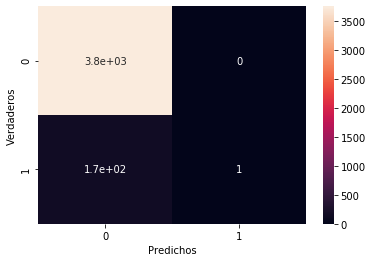

In [64]:
confusion_matrix(y_train, lr.predict(X_train_std))
sns.heatmap(confusion_matrix(y_train, lr.predict(X_train_std)), annot=True)
plt.ylabel('Verdaderos')
plt.xlabel('Predichos')

In [65]:
print(classification_report(y_train, lr.predict(X_train_std)))

              precision    recall  f1-score   support

           0       0.96      1.00      0.98      3758
           1       1.00      0.01      0.01       167

    accuracy                           0.96      3925
   macro avg       0.98      0.50      0.50      3925
weighted avg       0.96      0.96      0.94      3925



In [66]:
lr.predict_proba(X_train_std[y_train==0])[:,1]

array([0.006165  , 0.08000965, 0.03359629, ..., 0.04412101, 0.00645315,
       0.00323656])

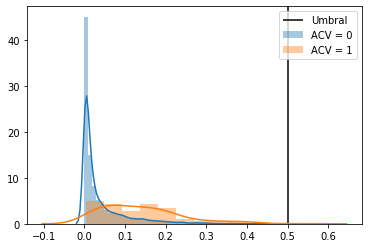

In [67]:
# Histograma de probabilidades
sns.distplot(lr.predict_proba(X_train_std[y_train==0])[:,1])
sns.distplot(lr.predict_proba(X_train_std[y_train==1])[:,1])
ylim = plt.ylim()
plt.vlines(0.5, ylim[0], ylim[1])
plt.ylim(ylim)
plt.legend(['Umbral', 'ACV = 0', 'ACV = 1'])

Vamos a buscar el mejor umbral

In [68]:
umbrales = [0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1]
Accuracy_list = []
Recall_list = []
Precision_list = []
TP_list = []
TN_list = []
FP_list = []
FN_list = []
for u in umbrales:
    umbral = u
    probs = lr.predict_proba(X_train_std)[:,1]
    y_pred_train = probs > umbral
    Accuracy = accuracy_score(y_train, y_pred_train)
    Recall = recall_score(y_train, y_pred_train)
    Precision = precision_score(y_train, y_pred_train)
    confusion = confusion_matrix(y_train, y_pred_train)
    Accuracy_list.append(Accuracy.round(2))
    Recall_list.append(Recall.round(2))
    Precision_list.append(Precision.round(2))
    
    
    TP_list.append(confusion[1, 1].astype(int))
    TN_list.append(confusion[0, 0].astype(int))
    FP_list.append(confusion[0, 1].astype(int))
    FN_list.append(confusion[1, 0].astype(int))


In [69]:
umbral = 0.01
probs = lr.predict_proba(X_train_std)[:,1]
y_pred_train = probs > umbral

In [70]:
print(Accuracy_list)

[0.47, 0.61, 0.68, 0.73, 0.76, 0.79, 0.81, 0.83, 0.85, 0.87]


In [71]:
tabla_umbral = pd.DataFrame([Accuracy_list, Recall_list, Precision_list, TP_list, TN_list, FP_list, FN_list], columns = umbrales, index = ['Accuracy', 'Recall', 'Precision','TP', 'TN', 'FP', 'FN'] )
tabla_umbral


,0.01,0.02,0.03,0.04,0.05,0.06,0.07,0.08,0.09,0.10
Accuracy,0.47,0.61,0.68,0.73,0.76,0.79,0.81,0.83,0.85,0.87
Recall,0.98,0.92,0.90,0.83,0.78,0.77,0.72,0.68,0.61,0.58
Precision,0.07,0.09,0.11,0.12,0.13,0.14,0.15,0.16,0.16,0.17
TP,163.00,153.00,150.00,139.00,131.00,128.00,121.00,114.00,102.00,97.00
TN,1674.00,2225.00,2519.00,2713.00,2865.00,2980.00,3073.00,3159.00,3237.00,3300.00
FP,2084.00,1533.00,1239.00,1045.00,893.00,778.00,685.00,599.00,521.00,458.00
FN,4.00,14.00,17.00,28.00,36.00,39.00,46.00,53.00,65.00,70.00


In [72]:
accuracy_score(y_train, y_pred_train)

0.46802547770700637

In [73]:
confusion = confusion_matrix(y_train, y_pred_train)

Text(33.0, 0.5, 'Reales')

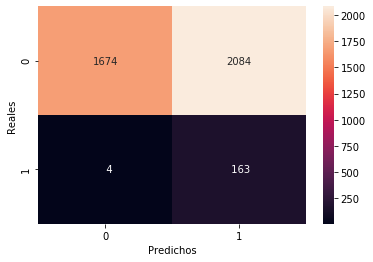

In [74]:
sns.heatmap(confusion_matrix(y_train, y_pred_train), annot=True, fmt='4d')
plt.xlabel('Predichos')
plt.ylabel('Reales')

In [75]:
print(classification_report(y_train, y_pred_train))

              precision    recall  f1-score   support

           0       1.00      0.45      0.62      3758
           1       0.07      0.98      0.14       167

    accuracy                           0.47      3925
   macro avg       0.54      0.71      0.38      3925
weighted avg       0.96      0.47      0.60      3925



In [76]:
# Specificity
TP = confusion[1, 1]
TN = confusion[0, 0]
FP = confusion[0, 1]
FN = confusion[1, 0]

specificity = TN / (TN + FP)

print(specificity)

0.4454497072911123


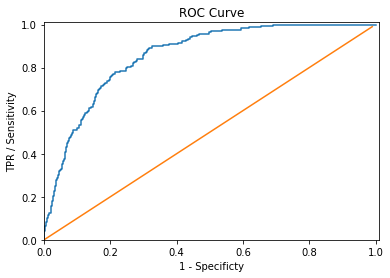

In [77]:
# ROC Curva y AUC
y_pred_proba = lr.predict_proba(X_train_std)

from sklearn.metrics import roc_curve
fpr_log,tpr_log,thr_log = roc_curve(y_train, y_pred_proba[:,1])

df = pd.DataFrame(dict(fpr=fpr_log, tpr=tpr_log, thr = thr_log))

plt.axis([0, 1.01, 0, 1.01])
plt.xlabel('1 - Specificty')
plt.ylabel('TPR / Sensitivity')
plt.title('ROC Curve')
plt.plot(df['fpr'],df['tpr'])
plt.plot(np.arange(0,1, step =0.01), np.arange(0,1, step =0.01))
plt.show()

In [78]:
from sklearn.metrics import auc
print('AUC=', auc(fpr_log, tpr_log))

AUC= 0.8561806668727473


In [79]:

probs_test = lr.predict_proba(X_test_std)[:,1]
y_pred_test = probs_test > umbral

Text(33.0, 0.5, 'Reales')

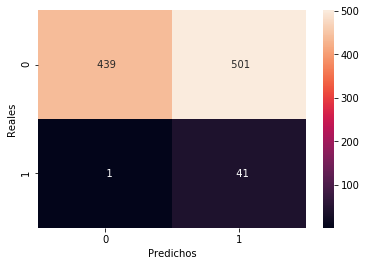

In [80]:
sns.heatmap(confusion_matrix(y_test, y_pred_test), annot=True, fmt='4d')
plt.xlabel('Predichos')
plt.ylabel('Reales')

In [81]:
print(classification_report(y_test, y_pred_test))

              precision    recall  f1-score   support

           0       1.00      0.47      0.64       940
           1       0.08      0.98      0.14        42

    accuracy                           0.49       982
   macro avg       0.54      0.72      0.39       982
weighted avg       0.96      0.49      0.62       982



### Pipeline y Gridsearch

In [82]:
pasos = [('preprocesamiento', StandardScaler()), ('clasificador', LogisticRegression(solver='lbfgs', max_iter=500))]
pipe = Pipeline(pasos)
from sklearn.svm import SVC

In [83]:
param_grid = [{'preprocesamiento':[StandardScaler(), MinMaxScaler(), None], 'clasificador': [KNeighborsClassifier()],'clasificador__n_neighbors':range(2,20,2), 'clasificador__weights':['uniform','distance']}, {'preprocesamiento':[StandardScaler(), MinMaxScaler(), None],'clasificador__penalty':['l2'], 'clasificador__C':[0.001, 0.01, 0.05, 0.1, 0.3, 0.5, 1, 5, 10, 50]},{'preprocesamiento':[StandardScaler(), MinMaxScaler(), None], 'clasificador': [GaussianNB()]}]     

In [84]:
folds=StratifiedKFold(n_splits=5,shuffle=True, random_state=42)

In [85]:
grid =GridSearchCV(pipe, param_grid, cv=folds)

In [86]:
grid.fit(X_train,y_train)

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
             error_score=nan,
             estimator=Pipeline(memory=None,
                                steps=[('preprocesamiento',
                                        StandardScaler(copy=True,
                                                       with_mean=True,
                                                       with_std=True)),
                                       ('clasificador',
                                        LogisticRegression(C=1.0,
                                                           class_weight=None,
                                                           dual=False,
                                                           fit_intercept=True,
                                                           intercept_scaling=1,
                                                           l1_ratio=None,
                                                           max_iter=500,
   

In [87]:
grid.best_estimator_

Pipeline(memory=None,
         steps=[('preprocesamiento',
                 MinMaxScaler(copy=True, feature_range=(0, 1))),
                ('clasificador',
                 LogisticRegression(C=0.3, class_weight=None, dual=False,
                                    fit_intercept=True, intercept_scaling=1,
                                    l1_ratio=None, max_iter=500,
                                    multi_class='auto', n_jobs=None,
                                    penalty='l2', random_state=None,
                                    solver='lbfgs', tol=0.0001, verbose=0,
                                    warm_start=False))],
         verbose=False)

In [88]:
grid.best_score_

0.9577070063694268

In [89]:
grid.best_params_

{'clasificador__C': 0.3,
 'clasificador__penalty': 'l2',
 'preprocesamiento': MinMaxScaler(copy=True, feature_range=(0, 1))}

In [90]:
y_predic_grid = grid.best_estimator_.predict(X_train)

In [91]:

probs_2 = grid.best_estimator_.predict_proba(X_train)[:,1]
y_pred_train_grid = probs_2 > umbral

Text(33.0, 0.5, 'Reales')

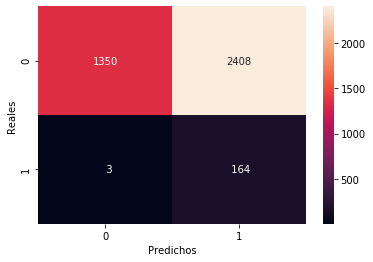

In [92]:
sns.heatmap(confusion_matrix(y_train, y_pred_train_grid), annot=True, fmt='4d')
plt.xlabel('Predichos')
plt.ylabel('Reales')

In [99]:
print(classification_report(y_train, y_pred_train_grid)) 

              precision    recall  f1-score   support

           0       1.00      0.36      0.53      3758
           1       0.06      0.98      0.12       167

    accuracy                           0.39      3925
   macro avg       0.53      0.67      0.32      3925
weighted avg       0.96      0.39      0.51      3925



In [94]:
probs_2 = grid.best_estimator_.predict_proba(X_test)[:,1]
y_pred_test_grid = probs_2 > umbral

Text(33.0, 0.5, 'Reales')

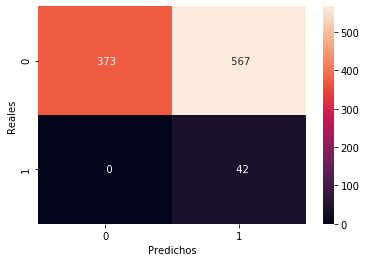

In [95]:
sns.heatmap(confusion_matrix(y_test, y_pred_test_grid), annot=True, fmt='4d')
plt.xlabel('Predichos')
plt.ylabel('Reales')

In [100]:
print(classification_report(y_test, y_pred_test_grid)) 

              precision    recall  f1-score   support

           0       1.00      0.40      0.57       940
           1       0.07      1.00      0.13        42

    accuracy                           0.42       982
   macro avg       0.53      0.70      0.35       982
weighted avg       0.96      0.42      0.55       982



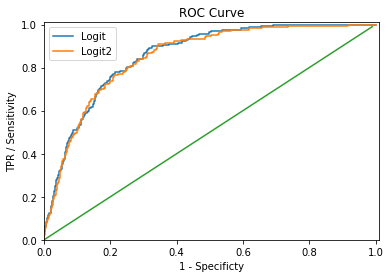

In [101]:
# ROC Curva y AUC
y_pred_proba_grid = grid.best_estimator_.predict_proba(X_train)

from sklearn.metrics import roc_curve
fpr_log,tpr_log,thr_log = roc_curve(y_train, y_pred_proba[:,1])
fpr_log2,tpr_log2,thr_log2 = roc_curve(y_train, y_pred_proba_grid[:,1])


df = pd.DataFrame(dict(fpr=fpr_log, tpr=tpr_log, thr = thr_log))
df_grid = pd.DataFrame(dict(fpr=fpr_log2, tpr=tpr_log2, thr = thr_log2))


plt.axis([0, 1.01, 0, 1.01])
plt.xlabel('1 - Specificty')
plt.ylabel('TPR / Sensitivity')
plt.title('ROC Curve')
plt.plot(df['fpr'],df['tpr'])
plt.plot(df_grid['fpr'],df_grid['tpr'])
plt.legend(['Logit', 'Logit2'])
plt.plot(np.arange(0,1, step =0.01), np.arange(0,1, step =0.01))
plt.show()

In [102]:
from sklearn.metrics import auc
print('AUC_2=', auc(fpr_log2, tpr_log2))
print('AUC=', auc(fpr_log, tpr_log))

AUC_2= 0.8504236869528639
AUC= 0.8561806668727473
